# LAB 3.1 - CNS (TDNN and RNN)

Import of libraries, fix of random seed and device.


In [1]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Callable
from tqdm.notebook import tqdm
import torch
import os

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cpu'

Loading of dataset NARMA10.

In [2]:
with open(f'NARMA10.csv') as file:
    data = file.read().split('\n')[:-1]
    X_narma10 = torch.Tensor([float(r) for r in data[0].split(',')]).to(device)
    Y_narma10 = torch.Tensor([float(r) for r in data[1].split(',')]).to(device)

X_narma10.shape, Y_narma10.shape

(torch.Size([10000]), torch.Size([10000]))

Split in train and test set for each X and Y data.

In [3]:
tr_size = 5000

TR_X_narma10 = X_narma10[:tr_size]
TR_Y_narma10 = Y_narma10[:tr_size]
TS_X_narma10 = X_narma10[tr_size:]
TS_Y_narma10 = Y_narma10[tr_size:]

TR_X_narma10.shape, TR_Y_narma10.shape, TS_X_narma10.shape, TS_Y_narma10.shape

(torch.Size([5000]),
 torch.Size([5000]),
 torch.Size([5000]),
 torch.Size([5000]))

Functions able to provide an easiest way to plot the results.

In [4]:
def _base_plot(
        elements: list[tuple],
        title: str = '',
        xlabel: str = '',
        ylabel: str = '',
        xscale=None,
        yscale=None,
        save_name=None
) -> None:
    """Function able to plot a list of elements."""
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for line, label in elements:
        plt.plot(line, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale is not None:
        plt.xscale(xscale)
    if yscale is not None:
        plt.yscale(yscale)
    plt.grid()
    plt.legend()
    if save_name is not None:
        plt.savefig(f'tdnn_and_rnn/plots/{save_name}.png')
    plt.show()


def plot_tr(
        data: torch.Tensor,
        prediction: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot the training y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_train'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of training set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
    )


def plot_ts(
        data: torch.Tensor,
        prediction: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot the test y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_test'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of test set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
    )


def plot_loss(
        tr_loss: list,
        ts_loss: list,
        save_name: str = None
) -> None:
    """Function able to plot the learning curve of training and test losses."""
    if save_name is not None:
        save_name = f'{save_name}_loss'
    _base_plot(
        [
            (tr_loss, 'TR loss'),
            (ts_loss, 'TS loss'),
        ],
        title='Loss (MSE) for epochs',
        xlabel='Epochs',
        ylabel='Loss (MSE)',
        save_name=save_name,
    )


def general_plot(
        train_loss: list,
        ts_loss: list,
        TR_Y: torch.Tensor,
        train_pred: torch.Tensor,
        TS_Y: torch.Tensor,
        eval_pred: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot all results of subplots related to learning curve, training data and test data."""
    plot_loss(train_loss, ts_loss, save_name=save_name)
    plot_tr(data=TR_Y, prediction=train_pred[-1], save_name=save_name)
    plot_ts(data=TS_Y, prediction=eval_pred[-1], save_name=save_name)

Train function able to fit a model given in input.

In [5]:
def train(
        model: torch.nn.Module,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 10,
        sgd_config: dict = {},
        tqdm=None,
        save_name: str = None,
) -> tuple:
    """
    Function able to train a given model.

    model: Model to train.
    TR: Tuple composed by X train and Y train torch tensors.
    TS: Tuple composed by X test and Y test torch tensors.
    epochs: Number of epochs of training.
    sgd_config: Dictionary containing sgd configurations (lr and momentum).
    tqdm: TQDM object to show the progressbar. It is None when progressbar is not shown.
    save_name: Name given to save the torch model and data in a file. If it is None the file is not created.

    returns:
        tuple: Results of training. In particular the tuple is composed by 4 variables:
            - train_loss: List of MSE loss of training set computed for each epoch.
            - test_loss: List of MSE loss of test set computed for each epoch.
            - train_preds: List of predictions of training set for each epoch.
            - test_preds: List of predictions of test set for each epoch.
    """
    optimizer = torch.optim.SGD(model.parameters(), **sgd_config)
    criterion = torch.nn.MSELoss()
    train_loss, test_loss = [], []
    train_preds, test_preds = [], []
    X_TR, Y_TR = TR
    X_TS, Y_TS = TS
    model.eval()
    test_loss.append(criterion(model(X_TS), Y_TS).item())

    iterable = range(epochs)
    if tqdm is not None:
        iterable = tqdm(iterable)
    for _ in iterable:
        model.train()
        optimizer.zero_grad()
        pred_tr = model(X_TR)
        loss_tr = criterion(pred_tr, Y_TR)
        loss_tr.backward()
        optimizer.step()
        train_loss.append(loss_tr.item())
        train_preds.append(pred_tr.cpu())

        model.eval()
        pred_vl = model(X_TS)
        test_loss.append(criterion(pred_vl, Y_TS).item())
        test_preds.append(pred_vl.cpu())

    train_loss.append(criterion(model(X_TR), Y_TR).item())
    if save_name is not None:
        torch.save({
            'model': model,
            'optimizer': optimizer,
            'train_loss': train_loss,
            'test_loss': test_loss[-1],
        }, f'tdnn_and_rnn/variables/{save_name}_model_and_tr_info.pt')
    return train_loss, test_loss, train_preds, test_preds

Gridsearch function able to find the best configuration for a model created in a `train_func` function callback, train the model with the best configuration and test it on test set.

In [6]:
def gridsearch(
        train_func: Callable,
        configs: dict,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 100,
        vl_tr_size: int = 4000,
        attempts_for_config: int = 1,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Gridsearch function able to find the best hyperparameters configuration, train the model with the best config and test it.

    train_func: Function able to create a model and train it given a config, a train and validation set and a number of epochs.
    configs: Hyperparameters configurations to investigate to find the best one that minimizes the loss on validation set. In particular this is a dictionary of lists for each hyperparam to investigate that is transformed by this function in a list of dictionaries.
    TR: Training set data (X, Y).
    TS: test set data (X, Y).
    epochs: Number of epochs of training both for model selection and model evaluation.
    vl_tr_size: Number of example to use in training set of model selection phase. It is useful to split training set in training and validation set.
    attempts_for_config: Number of attempts to do for each configuration. The loss that it's minimized is the mean of each loss of each attempt.
    save_name: Name used for saving the file related to mse info (mse of training, validation and test set).
    device: Name of device to use for computation.

    returns: A tuple of 4 variables related to the result of training function during the model evaluation phase (training on entire training set and test on test set).
    """
    configs = [dict(zip(configs.keys(), t)) for t in itertools.product(*configs.values())]
    best_config = {}
    best_loss = None
    X_TR, Y_TR = TR
    for i, config in enumerate(tqdm(configs)):
        vl_loss = 0
        for j in range(attempts_for_config):
            _, tdnn_eval_loss, _, _ = train_func(
                config,
                (X_TR[:vl_tr_size], Y_TR[:vl_tr_size]),
                (X_TR[vl_tr_size:], Y_TR[vl_tr_size:]),
                epochs=epochs,
                device=device,
            )
            vl_loss += tdnn_eval_loss[-1]
        vl_loss /= attempts_for_config
        print(f'{i + 1}/{len(configs)} - Tried config {config} with loss {vl_loss}')
        if best_loss is None or vl_loss < best_loss:
            best_config = config
            best_loss = vl_loss
    print(f'Best config: {best_config} with loss {best_loss}')
    print('Retraining...')
    train_loss, eval_loss, train_preds, eval_preds = train_func(
        best_config,
        TR,
        TS,
        epochs=epochs,
        tqdm=tqdm,
        save_name=save_name,
        device=device,
    )

    if save_name is not None:
        mse_data = {
            'train_mse': train_loss[-1],
            'validation_mse': best_loss,
            'test_mse': eval_loss[-1]
        }
        print(mse_data)
        with open(f'tdnn_and_rnn/variables/{save_name}_mse_data.json', 'w') as file:
            json.dump(mse_data, file)

    return train_loss, eval_loss, train_preds, eval_preds

### TDNN

Import TDNN pytorch model.

In [7]:
from src.model.tdnn import TDNN

TDNN(10, 100, 1, n_layers=2)

TDNN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

TDNN train function.

In [8]:
def train_tdnn(
        config: dict,
        TR: torch.Tensor,
        TS: torch.Tensor,
        epochs: int = 10,
        tqdm=None,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Function used to train the TDNN model. It wraps the general train function.

    config: Dictionary of hyperparameters.
    TR: Training set.
    TS: Test set.
    epochs: Number of epochs.
    tqdm: Object used to show the progressbar.
    save_name: Able to provide the title of file containing pytorch model and training info.
    device: Name of device to use for computation.

    returns:
        tuple: Train results.
    """
    window = config['window']
    model = TDNN(window, config['hidden_size'], 1, n_layers=config['n_layers'], device=device)
    sets = []
    for X, Y in [TR, TS]:
        X = torch.unsqueeze(X.unfold(0, window + 1, 1), 0)
        Y = Y[window:].reshape(1, -1, 1)
        sets.append((X, Y))
    return train(model, sets[0], sets[1], epochs=epochs, tqdm=tqdm, save_name=save_name, sgd_config={
        'lr': config['lr'],
        'momentum': config['momentum'],
    })

TDNN gridsearch and results.

In [9]:
tdnn_save_name = 'tdnn_narma10'

tdnn_train_loss, tdnn_ts_loss, tdnn_train_pred, tdnn_eval_pred = gridsearch(
    train_func=train_tdnn,
    configs=dict(
        window=[8, 10, 12],
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_narma10, TR_Y_narma10),
    TS=(TS_X_narma10, TS_Y_narma10),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=tdnn_save_name,
    device=device,
)

general_plot(tdnn_train_loss, tdnn_ts_loss, TR_Y_narma10.cpu(), tdnn_train_pred, TS_Y_narma10.cpu(), tdnn_eval_pred,
             save_name=tdnn_save_name)

  0%|          | 0/24 [00:00<?, ?it/s]

1/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.004451357759535313
2/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.004449639189988375
3/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.004484766162931919
4/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.004662542417645454
5/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.004451035987585783


### RNN

RNN pytorch model.

In [ ]:
from src.model.rnn import RNN

RNN(1, 100, 1)

RNN(
  (recoursive_layer): RNN(1, 100)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

RNN train function.

In [ ]:
def train_rnn(
        config: dict,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 10,
        tqdm=None,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Function used to train the RNN model. It wraps the general train function.

    config: Dictionary of hyperparameters.
    TR: Training set.
    TS: Test set.
    epochs: Number of epochs.
    tqdm: Object used to show the progressbar.
    save_name: Able to provide the title of file containing pytorch model and training info.
    device: Name of device to use for computation.

    returns:
        tuple: Train results.
    """
    model = RNN(TR[0].shape[-1], config['hidden_size'], TR[1].shape[-1], n_layers=config['n_layers'], device=device)
    return train(model, TR, TS, epochs=epochs, tqdm=tqdm, save_name=save_name, sgd_config={
        'lr': config['lr'],
        'momentum': config['momentum'],
    })

RNN gridsearch and results.

  0%|          | 0/4 [00:00<?, ?it/s]

1/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0044389758259058
2/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.004490434347341458
3/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.0063536022789776325
4/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.006584458363552888
Best config: {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0044389758259058
Retraining...


  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.004527154378592968, 'validation_mse': 0.0044389758259058, 'test_mse': 0.004180168733000755}


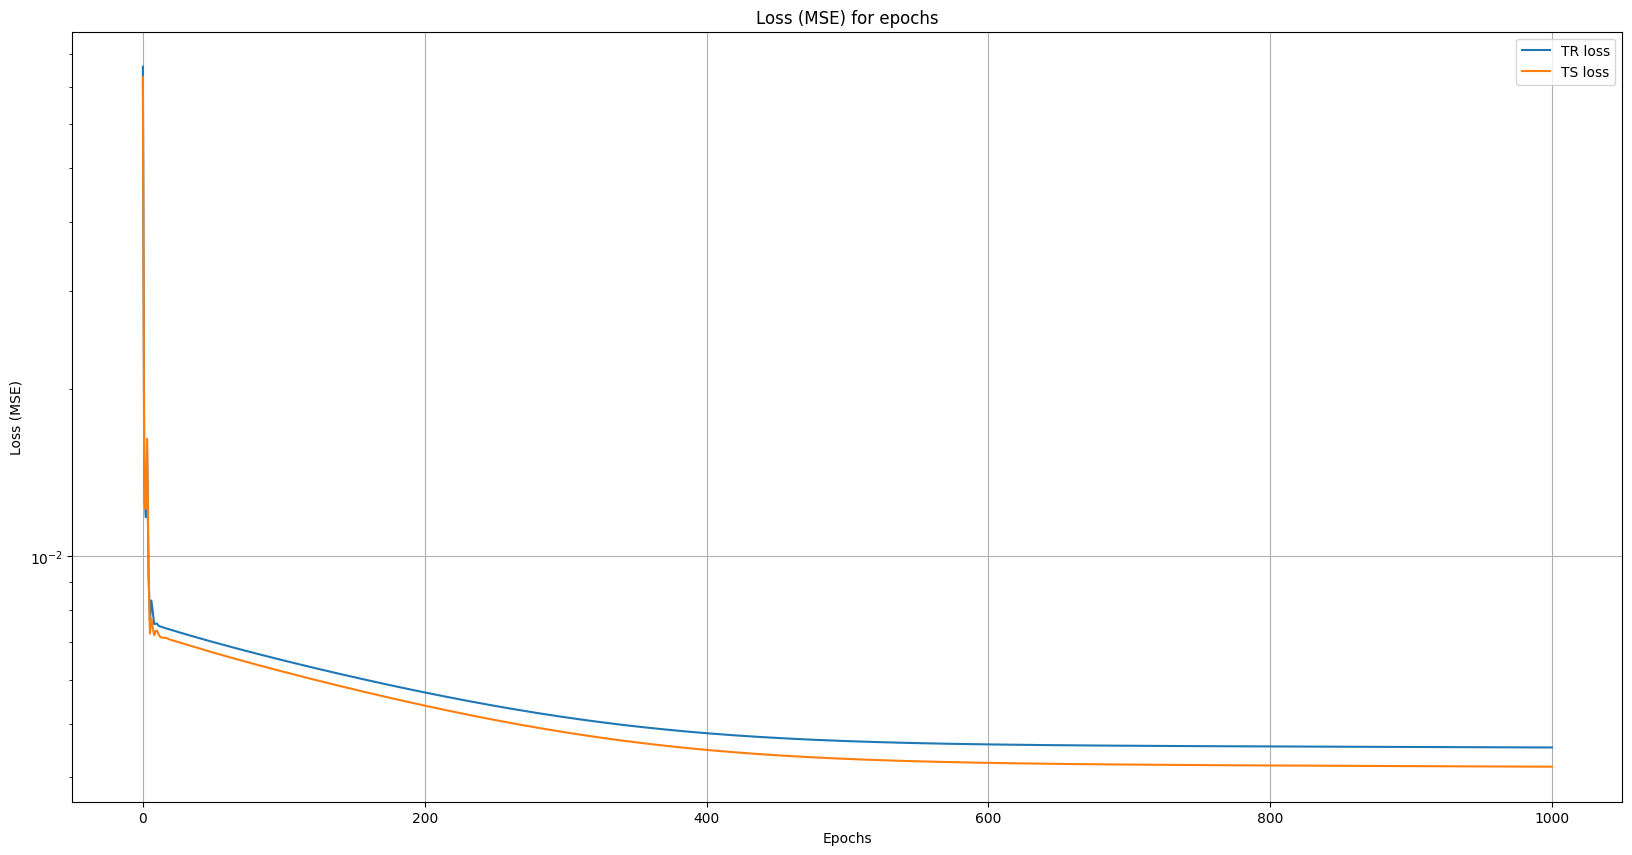

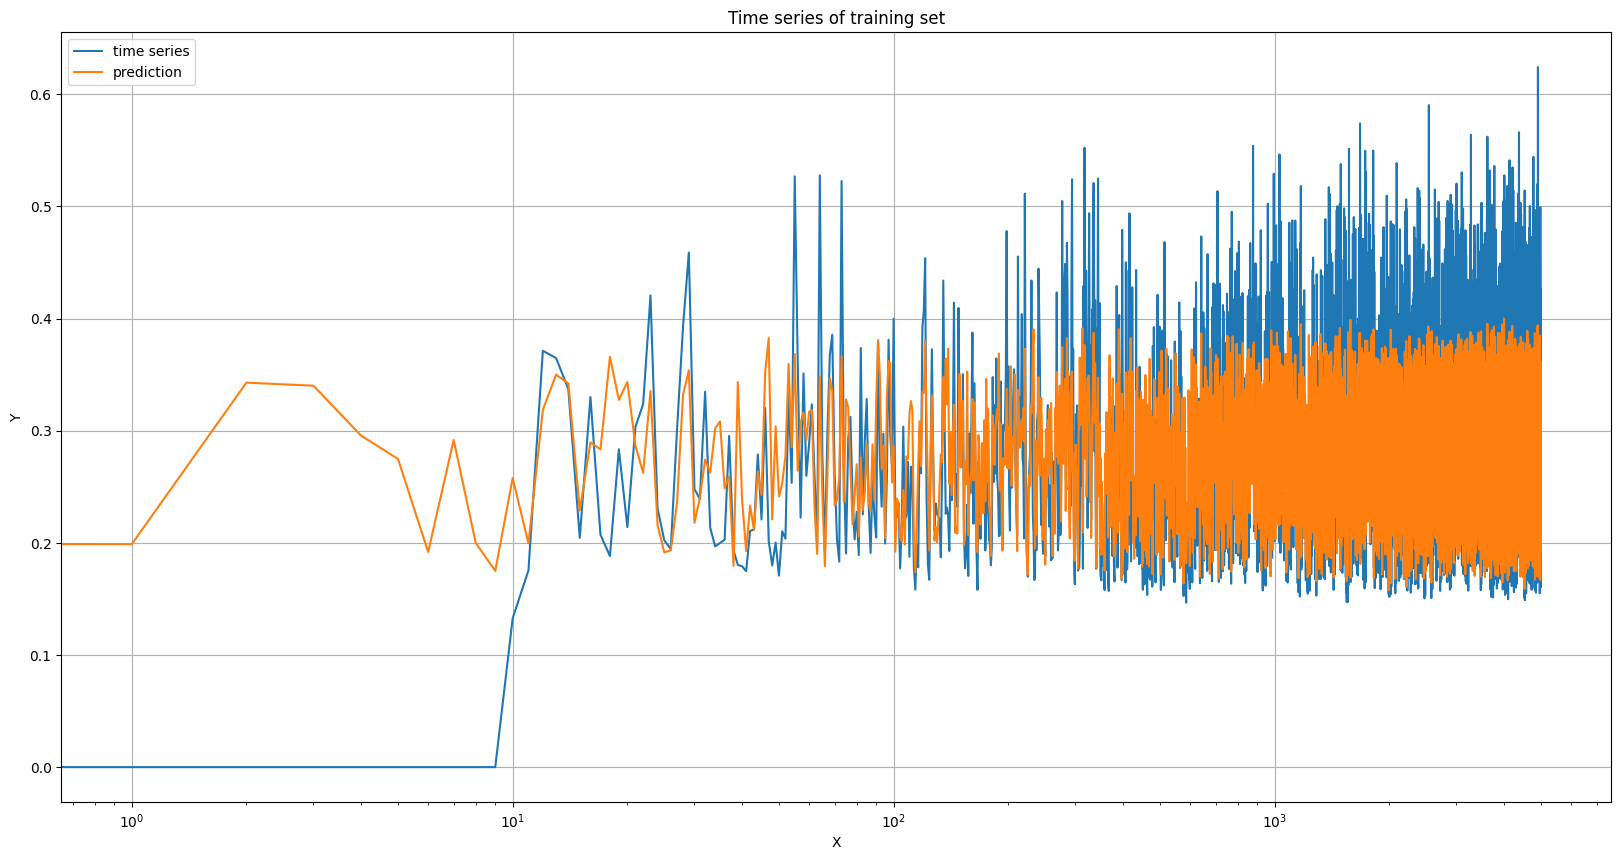

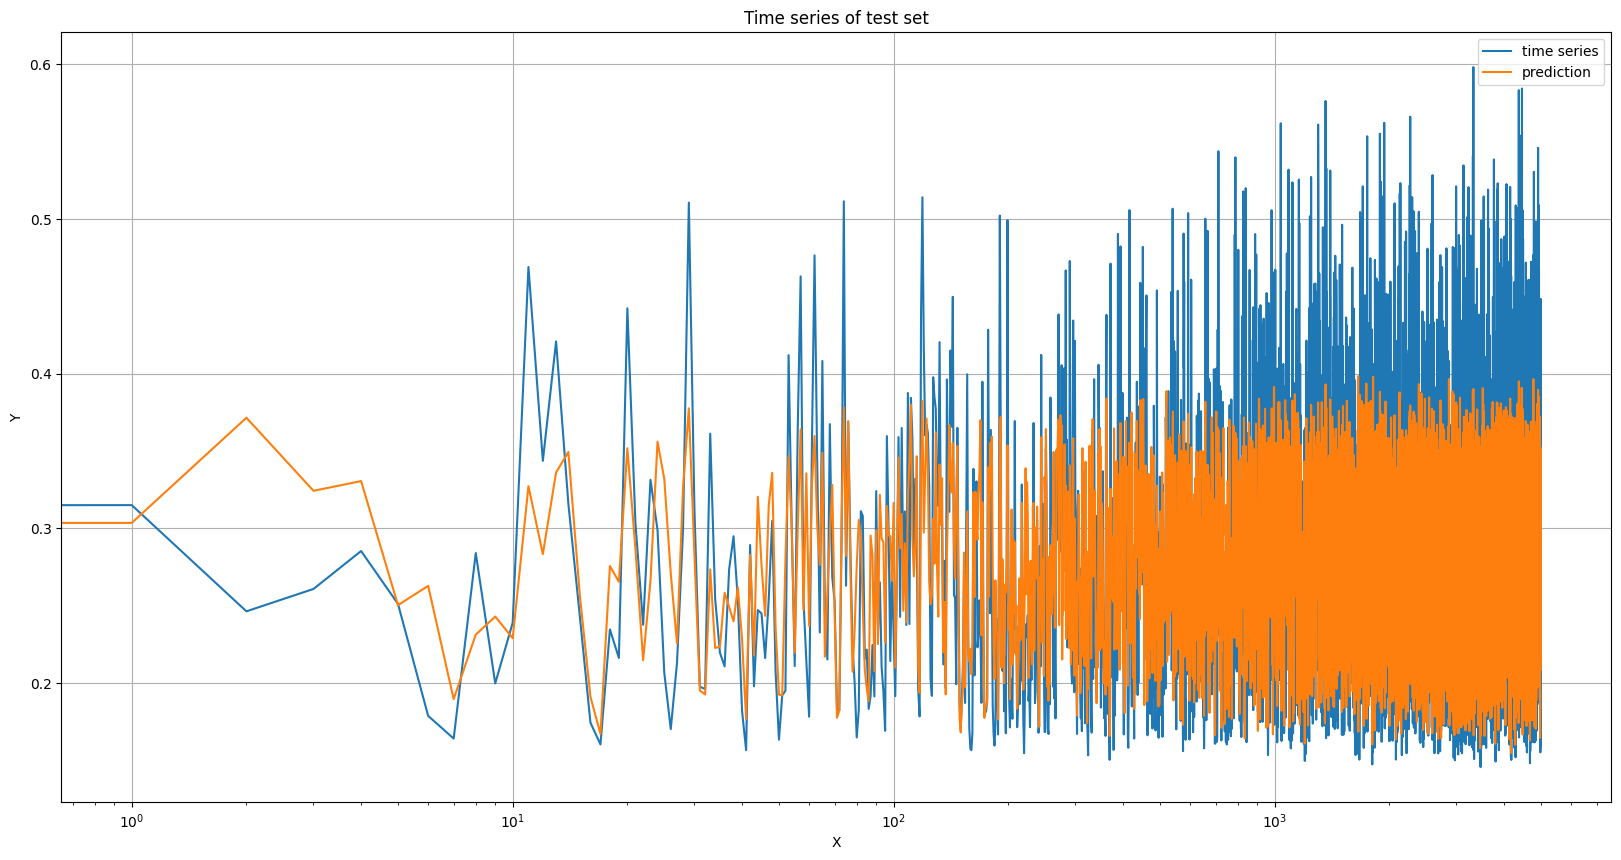

In [ ]:
rnn_save_name = 'rnn_narma10'

rnn_train_loss, rnn_ts_loss, rnn_train_pred, rnn_eval_pred = gridsearch(
    train_func=train_rnn,
    configs=dict(
        hidden_size=[100],
        n_layers=[1],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_narma10.reshape(-1, 1), TR_Y_narma10.reshape(-1, 1)),
    TS=(TS_X_narma10.reshape(-1, 1), TS_Y_narma10.reshape(-1, 1)),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=3,
    save_name=rnn_save_name,
    device=device,
)

general_plot(rnn_train_loss, rnn_ts_loss, TR_Y_narma10.cpu(), rnn_train_pred, TS_Y_narma10.cpu(), rnn_eval_pred,
             save_name=rnn_save_name)

# Bonus track 1 - Mackey-glass 17 task

Mackey-glass 17 task dataset loading and split in train and test set.

In [ ]:
tr_size = 5000

with open(f'MG17.csv') as file:
    data = file.read().split('\n')[:-1][0]
    data = torch.Tensor([float(r) for r in data.split(',')])
    TR_mg17 = data[:tr_size].to(device)
    TS_mg17 = data[tr_size:].to(device)

TR_X_mg17 = TR_mg17[:-1]
TR_Y_mg17 = TR_mg17[1:]
TS_X_mg17 = TS_mg17[:-1]
TS_Y_mg17 = TS_mg17[1:]

TR_X_mg17.shape, TR_Y_mg17.shape, TS_X_mg17.shape, TS_Y_mg17.shape

(torch.Size([4999]),
 torch.Size([4999]),
 torch.Size([4999]),
 torch.Size([4999]))

### TDNN

TDNN gridsearch and results.

  0%|          | 0/24 [00:00<?, ?it/s]

1/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.00017707807710394264
2/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.00030650687403976917
3/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.0008505953359417617
4/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.0011410791426897048
5/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.00022764693421777337
6/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.00033987456117756665
7/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.5} with loss 0.0009976054774597288
8/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum

  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.00019710036576725543, 'validation_mse': 0.0001744019304169342, 'test_mse': 0.00019589581643231213}


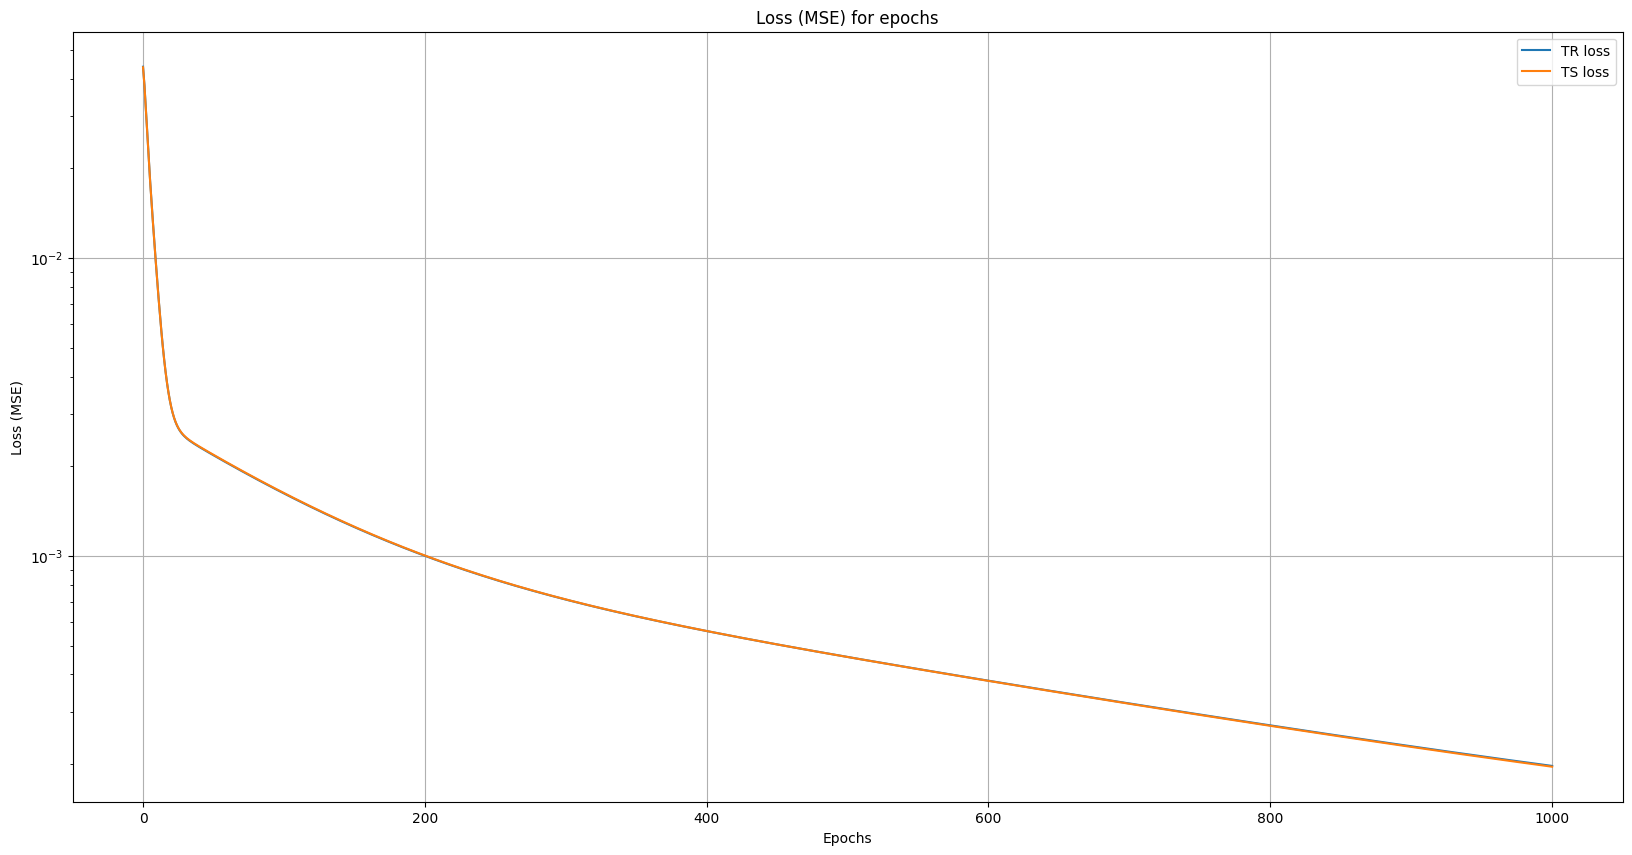

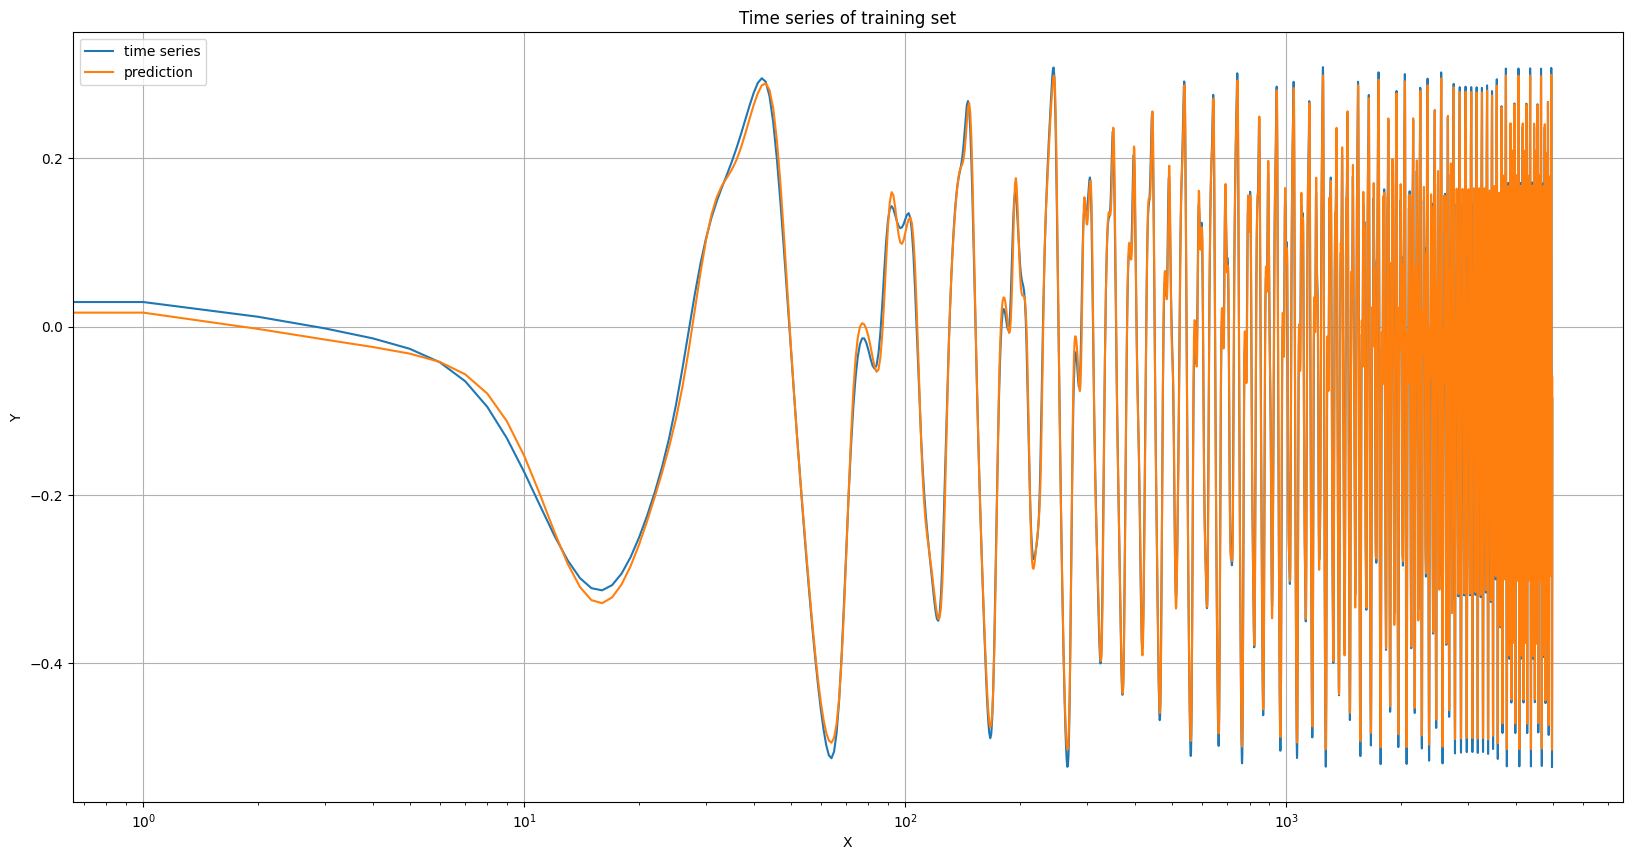

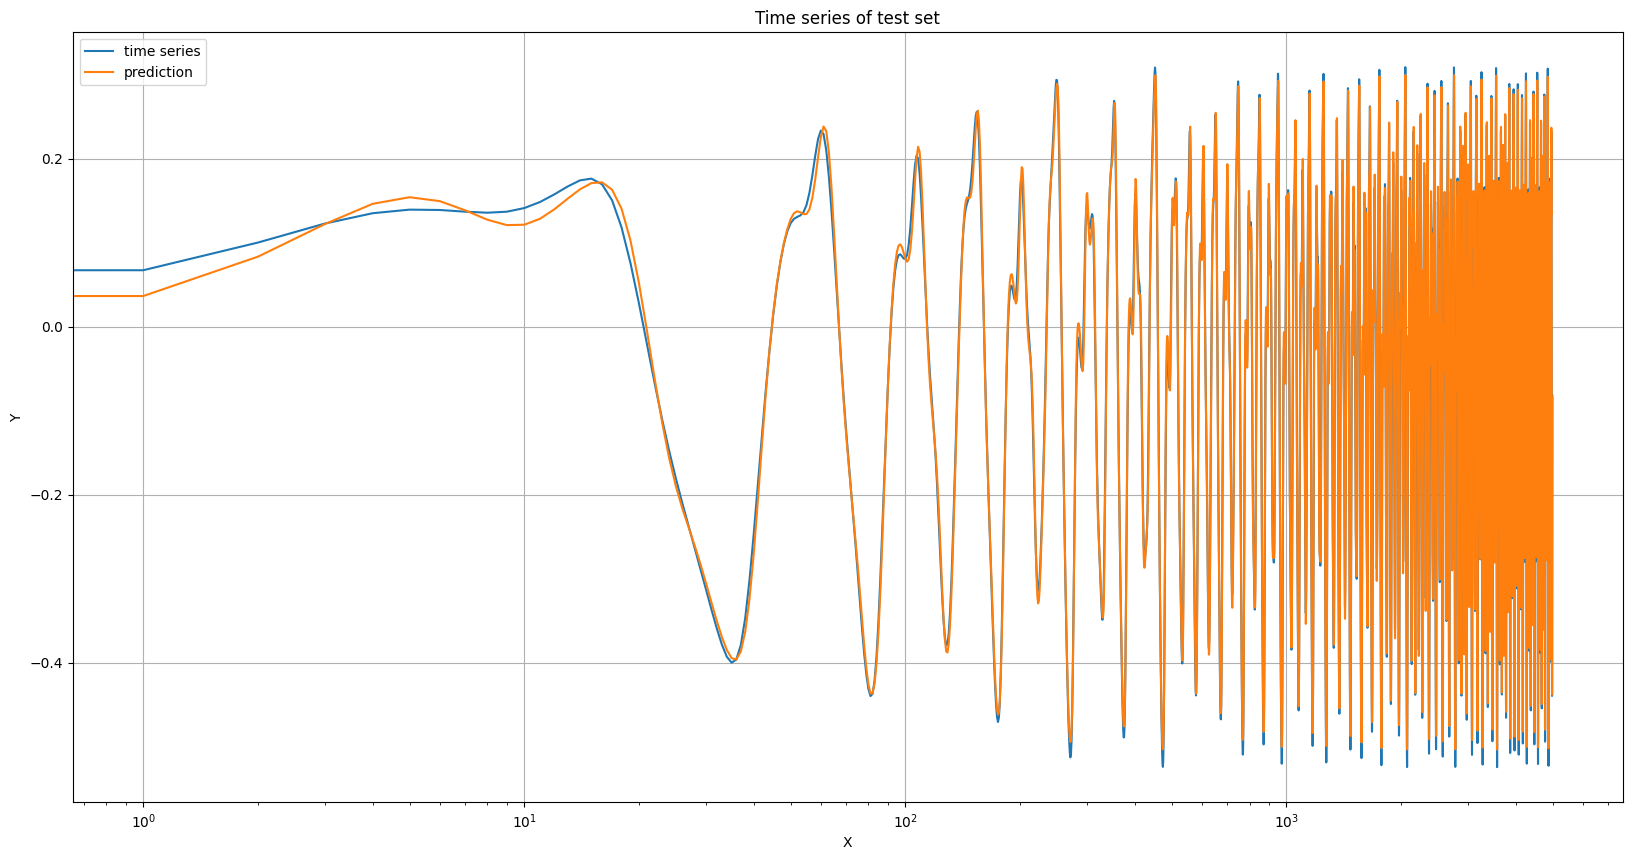

In [ ]:
tdnn_save_name = 'tdnn_mg17'

tdnn_train_loss, tdnn_ts_loss, tdnn_train_pred, tdnn_eval_pred = gridsearch(
    train_func=train_tdnn,
    configs=dict(
        window=[8, 10, 12],
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_mg17, TR_Y_mg17),
    TS=(TS_X_mg17, TS_Y_mg17),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=tdnn_save_name,
    device=device,
)

general_plot(tdnn_train_loss, tdnn_ts_loss, TR_Y_mg17.cpu(), tdnn_train_pred, TS_Y_mg17.cpu(), tdnn_eval_pred,
             save_name=tdnn_save_name)

### RNN

RNN gridsearch and results.

  0%|          | 0/4 [00:00<?, ?it/s]

1/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0002318461968873938
2/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.00030628652893938124
3/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.002238125695536534
4/4 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.003340895287692547
Best config: {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0002318461968873938
Retraining...


  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.00021717080380767584, 'validation_mse': 0.0002318461968873938, 'test_mse': 0.0002163979661418125}


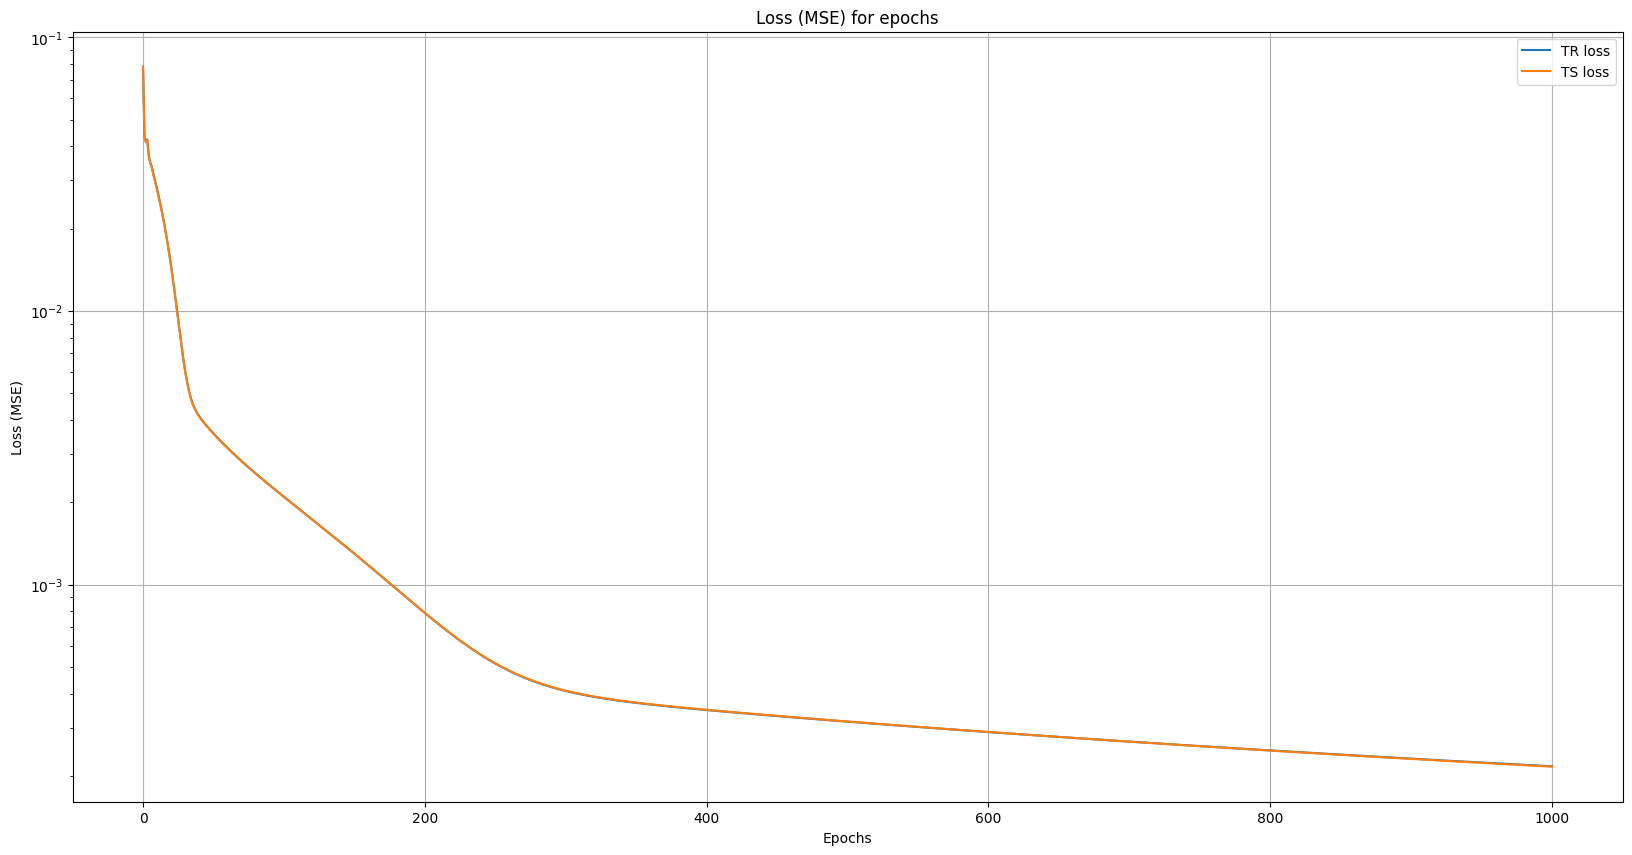

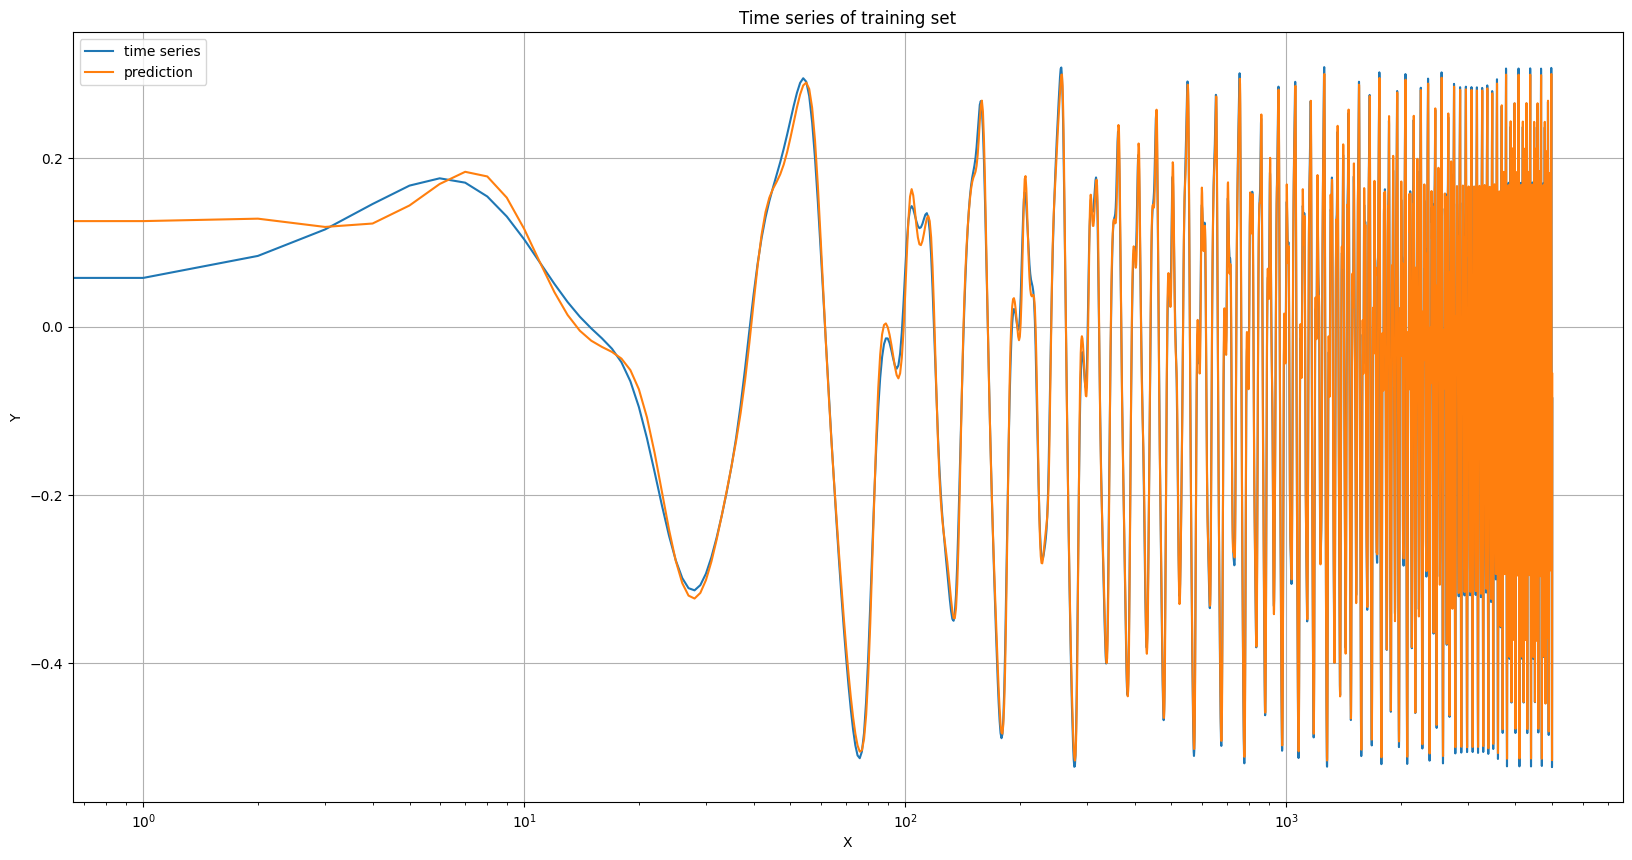

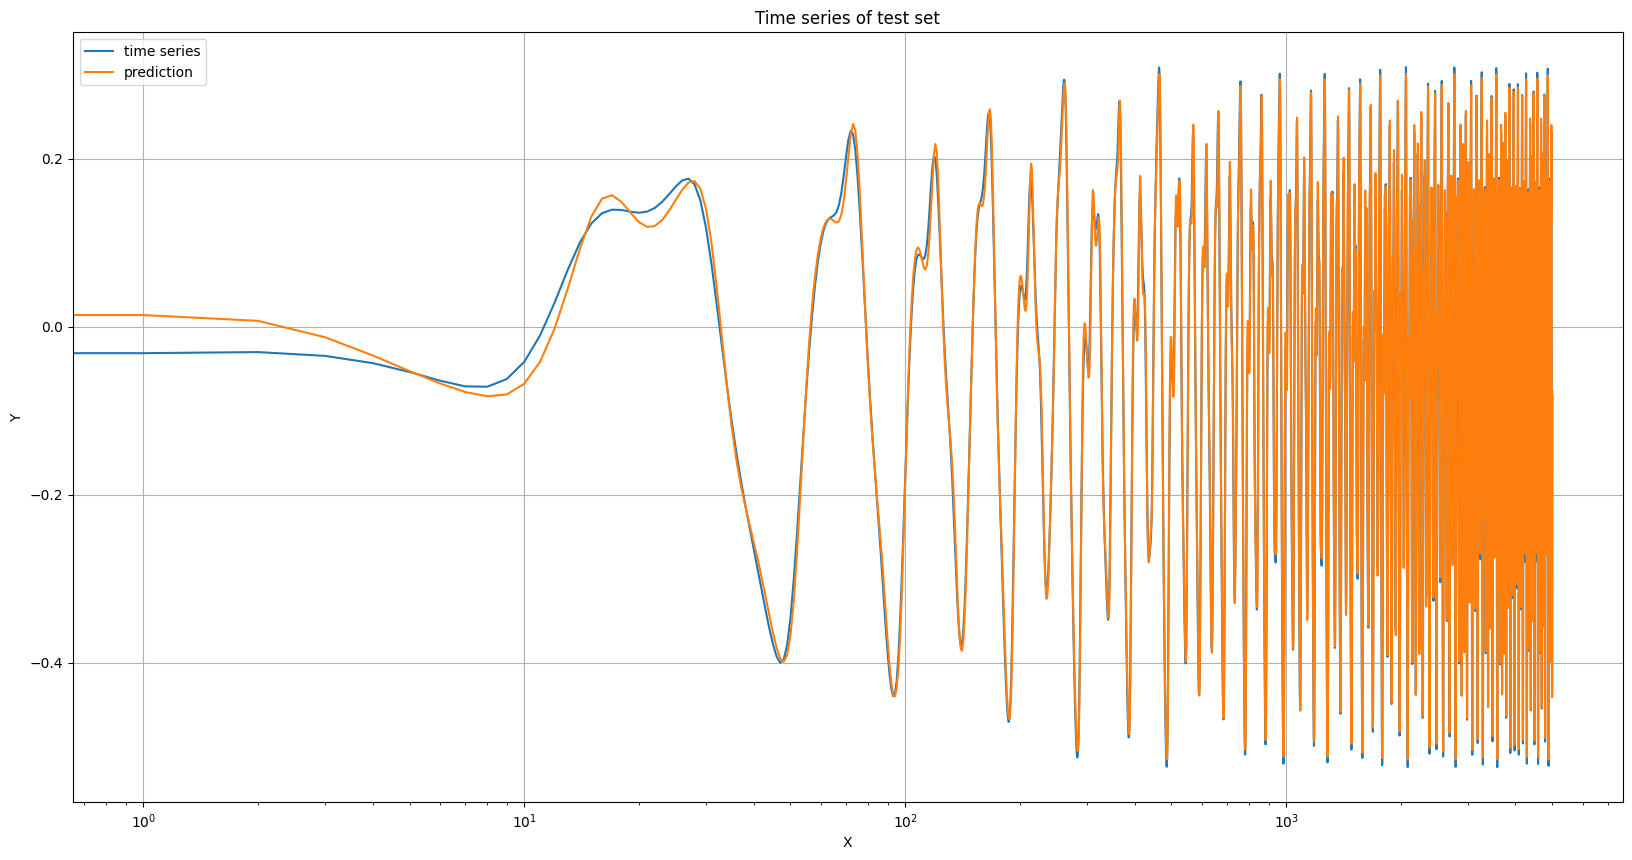

In [ ]:
rnn_save_name = 'rnn_mg17'

rnn_train_loss, rnn_ts_loss, rnn_train_pred, rnn_eval_pred = gridsearch(
    train_func=train_rnn,
    configs=dict(
        hidden_size=[100],
        n_layers=[1],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_mg17.reshape(-1, 1), TR_Y_mg17.reshape(-1, 1)),
    TS=(TS_X_mg17.reshape(-1, 1), TS_Y_mg17.reshape(-1, 1)),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=3,
    save_name=rnn_save_name,
    device=device,
)

general_plot(rnn_train_loss, rnn_ts_loss, TR_Y_mg17.cpu(), rnn_train_pred, TS_Y_mg17.cpu(), rnn_eval_pred,
             save_name=rnn_save_name)